In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Reshape,Flatten,Dense,Dropout
from tensorflow.keras.layers import BatchNormalization,Activation,LeakyReLU,UpSampling2D,Conv2D
from keras.models import Sequential,Model

import numpy as np
import matplotlib.pyplot as plt

In [2]:
generator = Sequential()
generator.add(Dense(128*7*7,input_dim=100,activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=5,padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1,kernel_size=5,padding='same',activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [3]:
discriminator = Sequential()
discriminator.add(Conv2D(64,kernel_size=5,strides=2,input_shape=(28,28,1),padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [4]:
ginput=Input(shape=(100,))
dis_output=discriminator(generator(ginput))
gan=Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy',optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


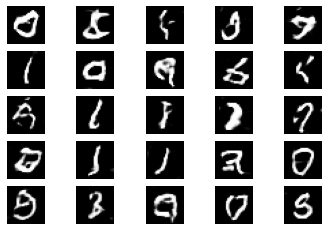

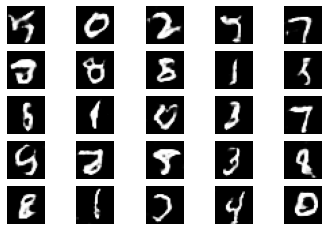

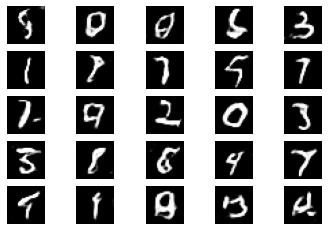

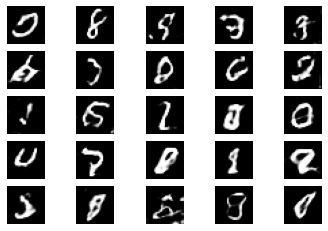

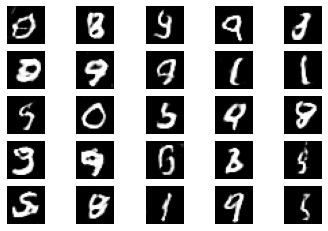

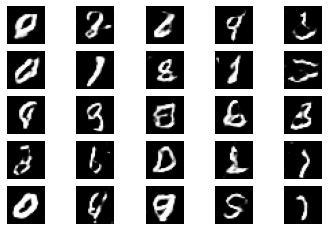

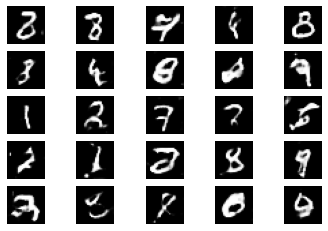

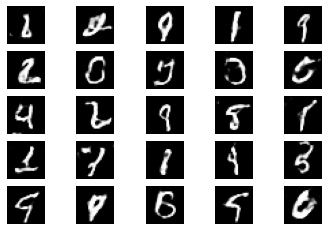

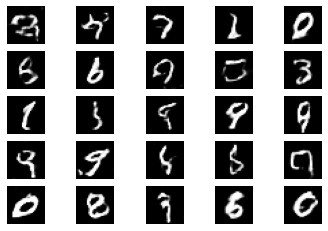

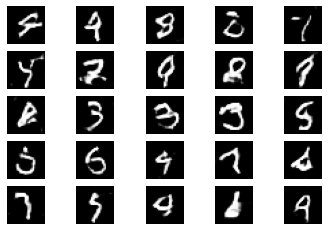

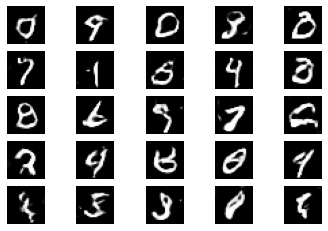

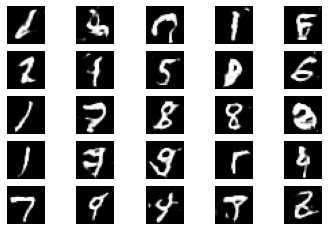

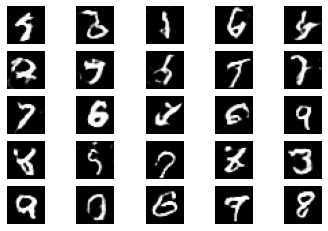

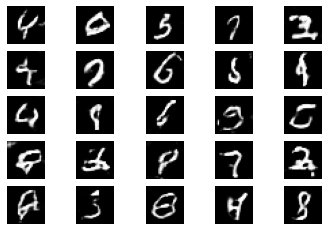

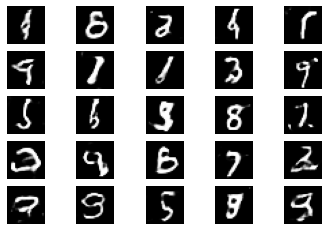

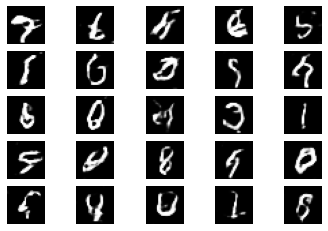

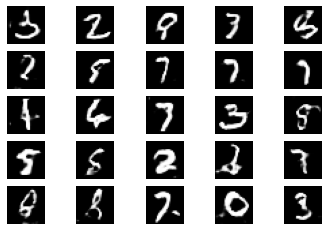

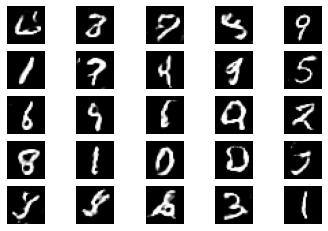

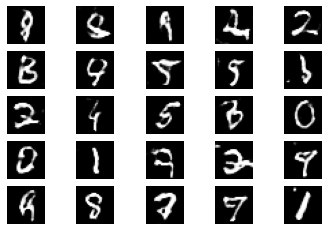

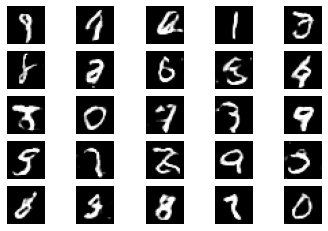

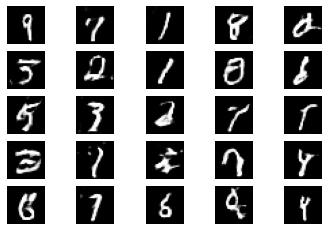

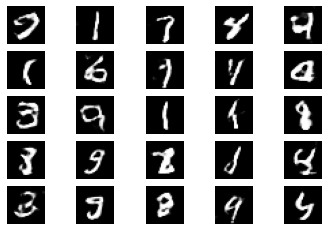

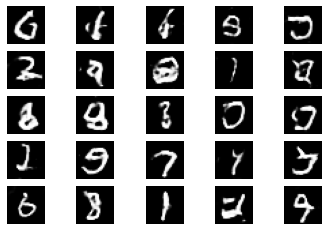

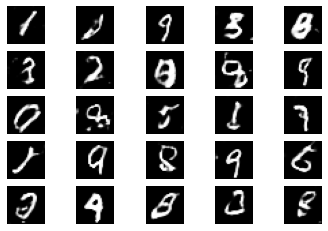

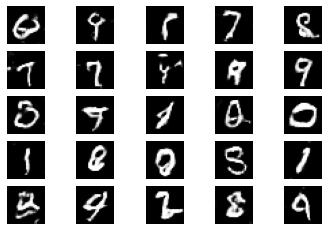

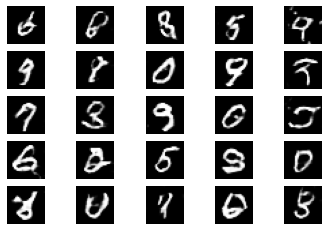

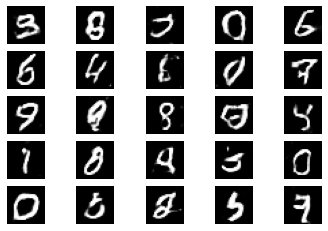

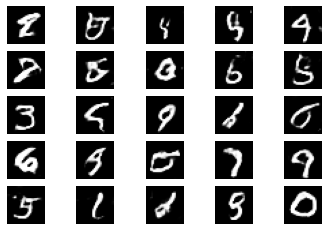

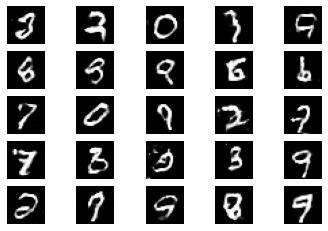

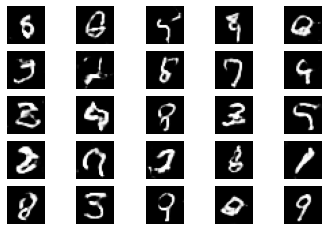

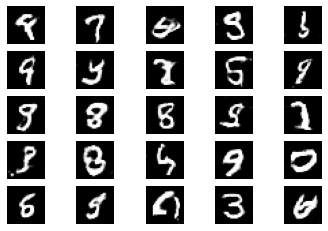

In [11]:

def gan_train(epoch,batch_size,saving_interval):
  (X_train,_),(_,_)=mnist.load_data()
  X_train=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
  X_train=(X_train-127.5)/127.5
  true=np.ones((batch_size,1))
  fake=np.zeros((batch_size,1))
  for i in range(epoch):
    idx=np.random.randint(0,X_train.shape[0],batch_size)
    imgs=X_train[idx]
    d_loss_real=discriminator.train_on_batch(imgs,true)
    noise=np.random.normal(0,1,(batch_size,100))
    gen_imgs=generator.predict(noise)
    d_loss_fake=discriminator.train_on_batch(gen_imgs,fake)
    d_loss=0.5*np.add(d_loss_real,d_loss_fake)
    g_loss=gan.train_on_batch(noise,true)
    # print('epoch:%d' %i,'d_loss:%.4f'% d_loss,'g_loss:%.4f'% g_loss)
    if i % saving_interval==0:
      noise=np.random.normal(0,1,(25,100))
      gen_imgs=generator.predict(noise)
      gen_imgs=0.5*gen_imgs+0.5
      fig,axs=plt.subplots(5,5)
      count=0
      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[count,:,:,0],cmap='gray')
          axs[j,k].axis('off')
          count+=1
      fig.savefig('gan_images/gan_mnist_%d.png'%i)
gan_train(6001,32,200)